In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

/tmp/ipykernel_2546/82325636.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

In [5]:
# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error

In [8]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)

In [11]:
# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

In [12]:
import scipy.stats as stats

In [15]:
import seaborn as sns

In [16]:
dades_2021_Marc_info = pd.read_csv('../dades/2021/BicingNou_ESTACIONS/2021_03_Marc_BicingNou_ESTACIONS.csv')

In [26]:
def get_features_nans(df:pd.DataFrame):
    result = (df.isna().sum()/df.shape[0])*100
    return result[result > 0].to_dict()

def get_features_zero(df:pd.DataFrame):
    result = (df.isin([0]).sum()/df.shape[0])*100
    return result[result > 0].to_dict()

def get_nans_counts(df:pd.DataFrame, column:str, mean_of_column:str, mean_of_value):
    return df[df[mean_of_column] == mean_of_value][column].isna().sum()

def get_columns(df: pd.DataFrame, cat_only:bool=False, num_only:bool=False) -> dict:
    if cat_only:
        cat_col = df.select_dtypes(include=['object']).columns
        return {col:len(set(df[col])) for col in cat_col}
    if num_only:
        num_col = df.select_dtypes(exclude=['object']).columns
        return {col:len(set(df[col])) for col in num_col}
    return {col:len(set(df[col])) for col in df.columns}

In [33]:
def show_column_counts(df:pd.DataFrame, column:str):
    assert column != ''
    assert df[column] is not None
    
    
    fig, axs = plt.subplots(3, 2, figsize=(20,10))
    axs[0][0].hist(df[column], label=f'{column} hist',bins=40)
    axs[0][0].set_xlabel('values')
    axs[0][0].set_ylabel('counts')
    axs[0][0].set_title('')

    axs[0][1].scatter(df[column].index, df[column].values, label=f'{column} scatter')
    axs[0][1].set_xlabel('index')
    axs[0][1].set_ylabel('values')
    axs[0][1].set_title('')
    
    axs[1][0].scatter(df[column].value_counts().index, df[column].value_counts().values,label=f'{column} counts')
    axs[1][0].set_xlabel('values')
    axs[1][0].set_ylabel('counts')
    axs[1][0].set_title('')
    
    axs[1][1].hist(df[column].value_counts(),label=f'{column} counts', bins=df[column].value_counts().shape[0])
    axs[1][1].set_xlabel('counts')
    axs[1][1].set_ylabel('values')
    axs[1][1].set_title('')
    
    
    axs[2][0].hist(df[column], density=True, histtype='step', cumulative=True,  linewidth=3.5, bins=30, color=sns.desaturate("indianred", .75))
    axs[2][0].set_xlabel('values')
    axs[2][0].set_ylabel('counts')
    axs[2][0].set_title('')
    
    axs[2][1].boxplot(df[column])
    axs[2][1].set_xlabel('counts')
    axs[2][1].set_ylabel('values')
    axs[2][1].set_title('')

    plt.tight_layout()
    plt.show()

In [18]:
dades_2021_Marc_info.head()

,station_id,num_bikes_available,num_bikes_available_types.mechanical,num_bikes_available_types.ebike,num_docks_available,last_reported,is_charging_station,status,is_installed,is_renting,is_returning,last_updated,ttl
0,1,19,18,1,25,1.614553e+09,True,IN_SERVICE,1,1,1,1614553243,27
1,2,21,21,0,5,1.614553e+09,True,IN_SERVICE,1,1,1,1614553243,27
2,3,19,18,1,6,1.614553e+09,True,IN_SERVICE,1,1,1,1614553243,27
3,4,4,4,0,14,1.614553e+09,True,IN_SERVICE,1,1,1,1614553243,27
4,5,17,17,0,22,1.614553e+09,True,IN_SERVICE,1,1,1,1614553243,27


In [25]:
dades_2021_Marc_info.shape

(4528030, 13)

In [28]:
get_features_nans(dades_2021_Marc_info)

{}

In [29]:
get_features_zero(dades_2021_Marc_info)

{'num_bikes_available': 8.928165228587266,
 'num_bikes_available_types.mechanical': 22.01635148177022,
 'num_bikes_available_types.ebike': 40.66348942034394,
 'num_docks_available': 3.110690521043368,
 'is_installed': 0.047901626093466695,
 'is_renting': 0.13727824241447165,
 'is_returning': 0.13727824241447165,
 'ttl': 0.8071722139650135}

In [31]:
get_columns(dades_2021_Marc_info)

{'station_id': 509,
 'num_bikes_available': 55,
 'num_bikes_available_types.mechanical': 55,
 'num_bikes_available_types.ebike': 30,
 'num_docks_available': 55,
 'last_reported': 2030499,
 'is_charging_station': 1,
 'status': 4,
 'is_installed': 2,
 'is_renting': 2,
 'is_returning': 2,
 'last_updated': 8908,
 'ttl': 31}

# Num bikes available

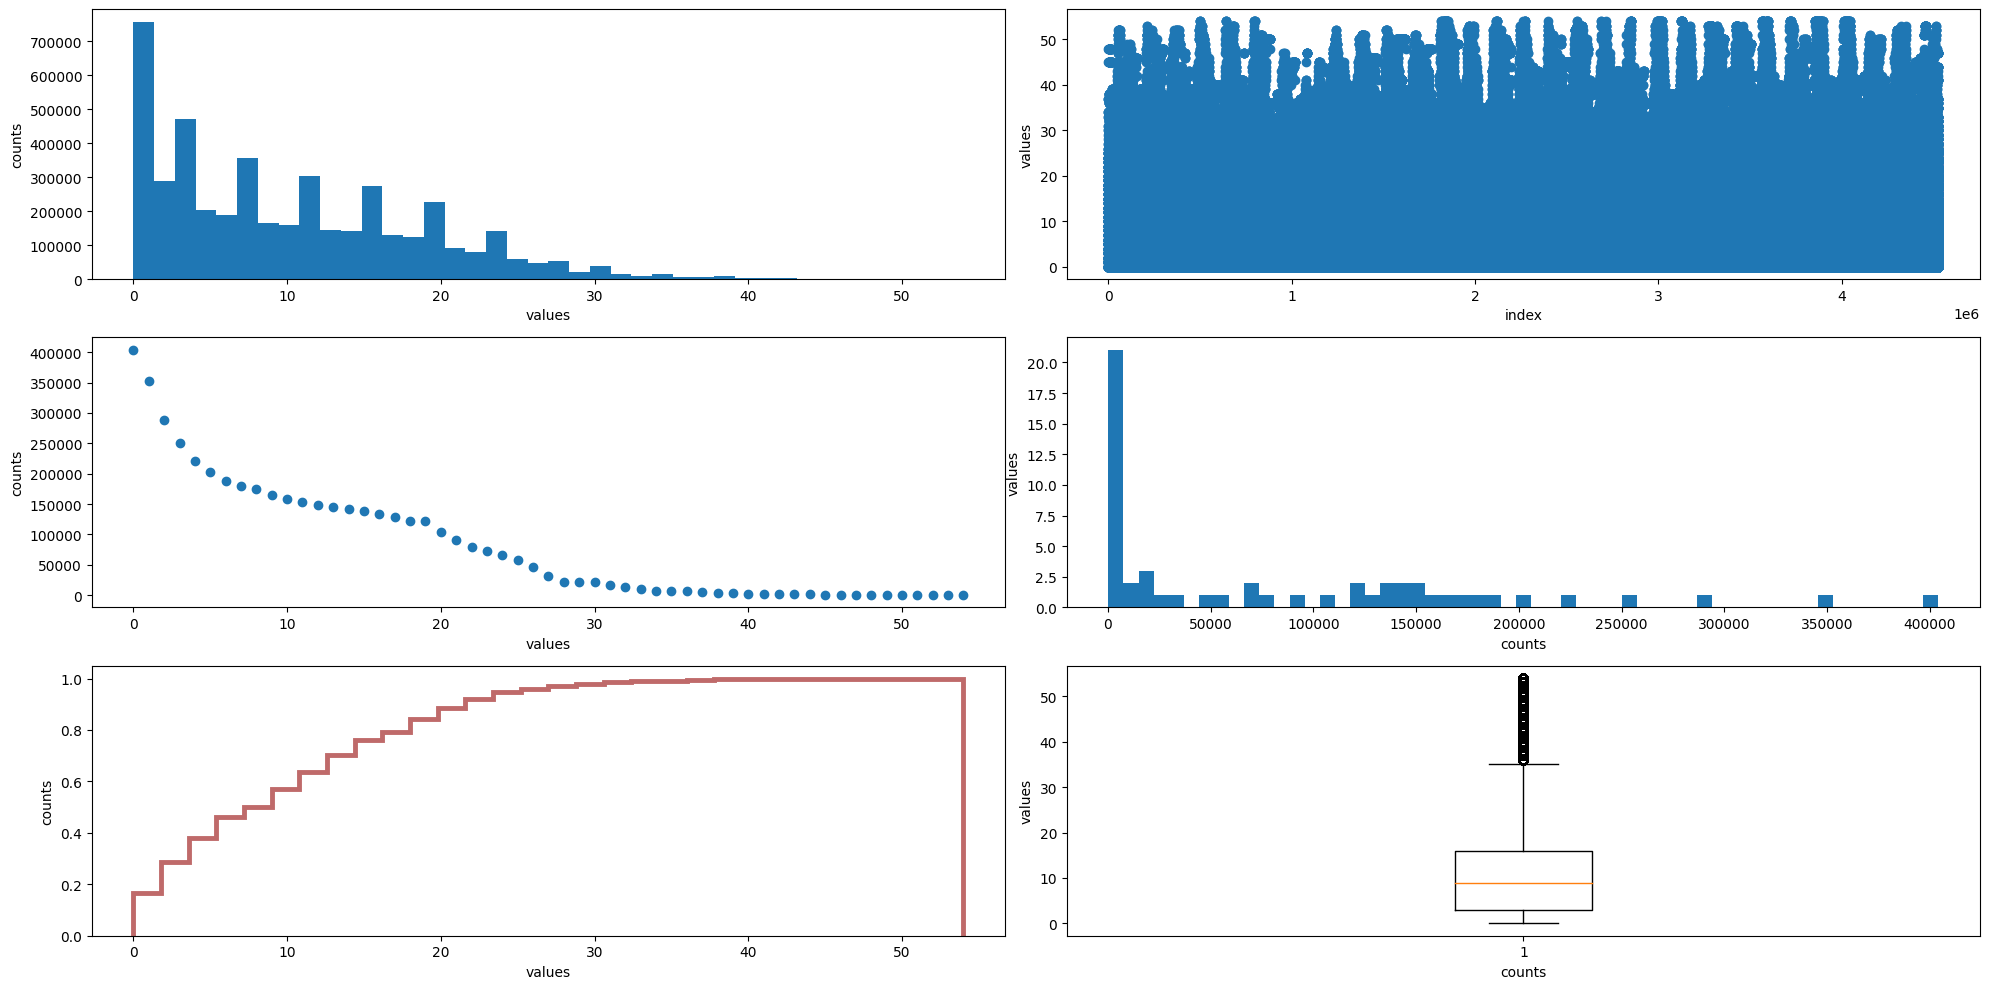

In [34]:
show_column_counts(dades_2021_Marc_info, 'num_bikes_available')

# Num bikes available (mechanical)

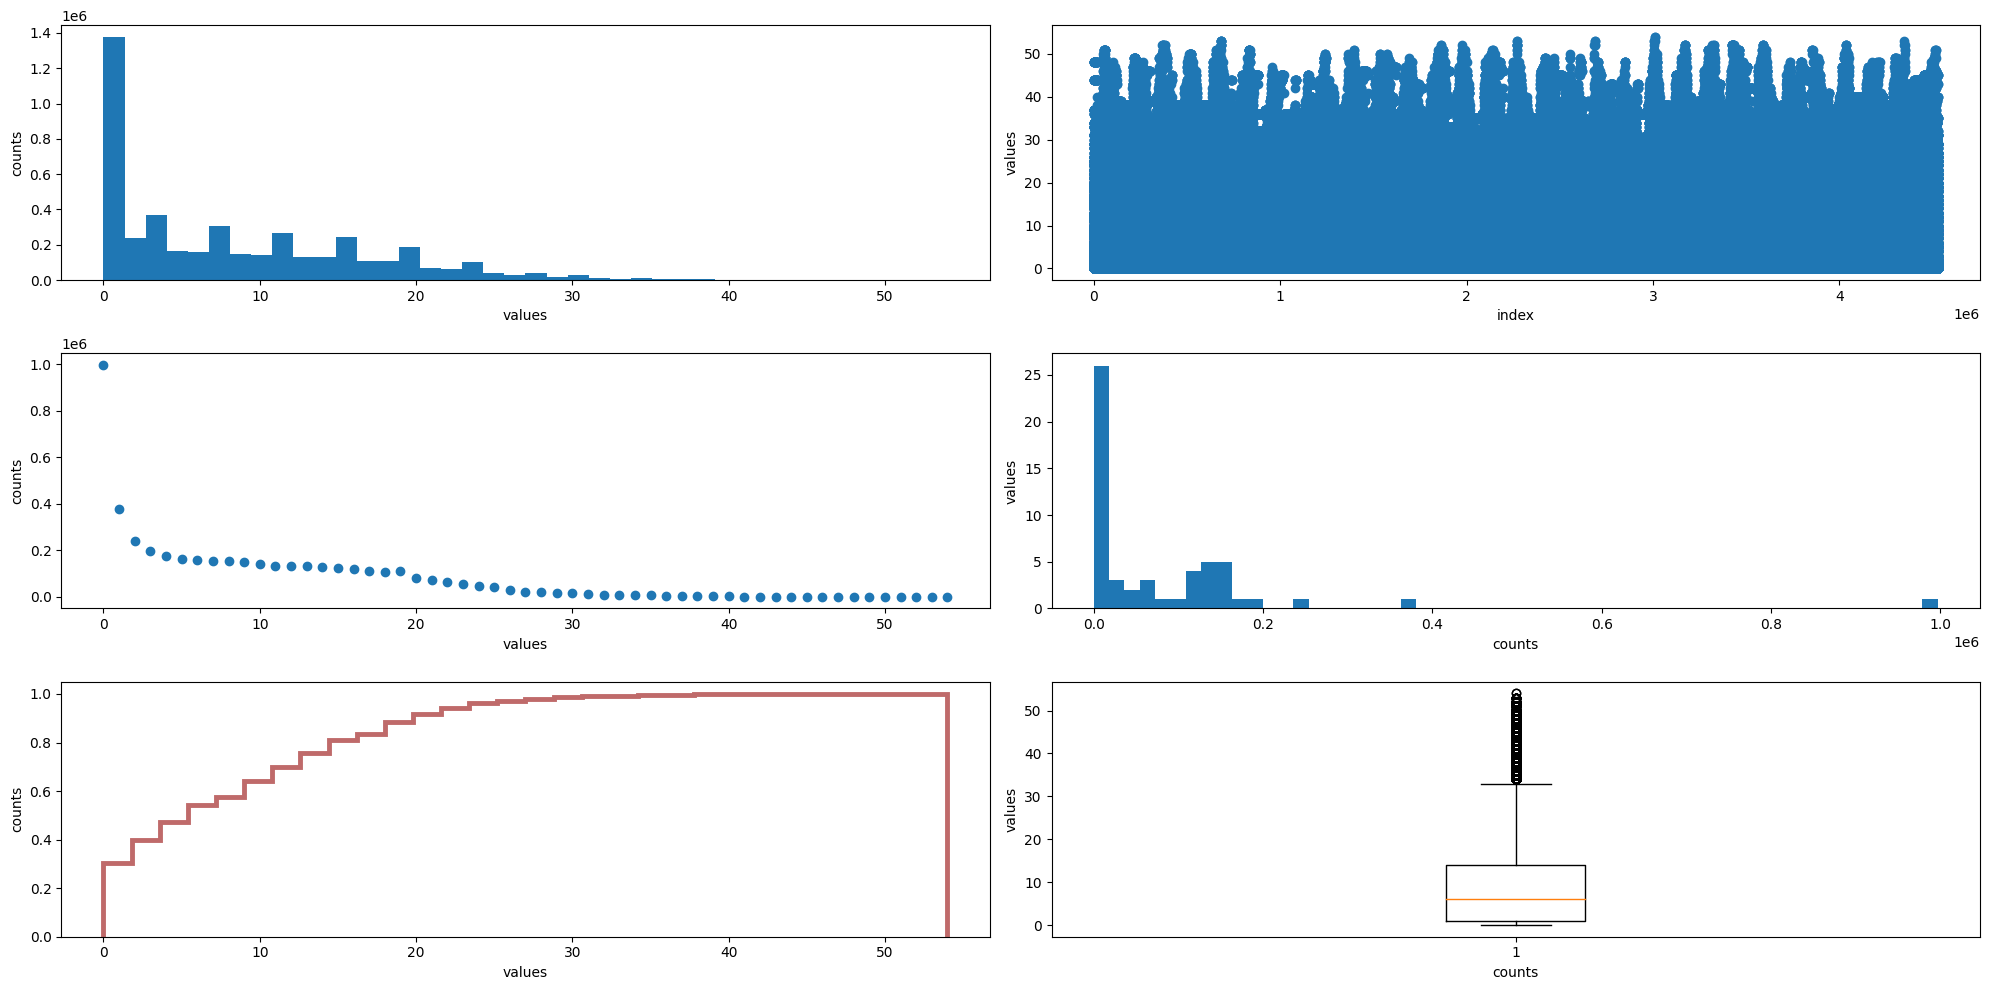

In [35]:
show_column_counts(dades_2021_Marc_info, 'num_bikes_available_types.mechanical')

# Num bikes available (ebike)

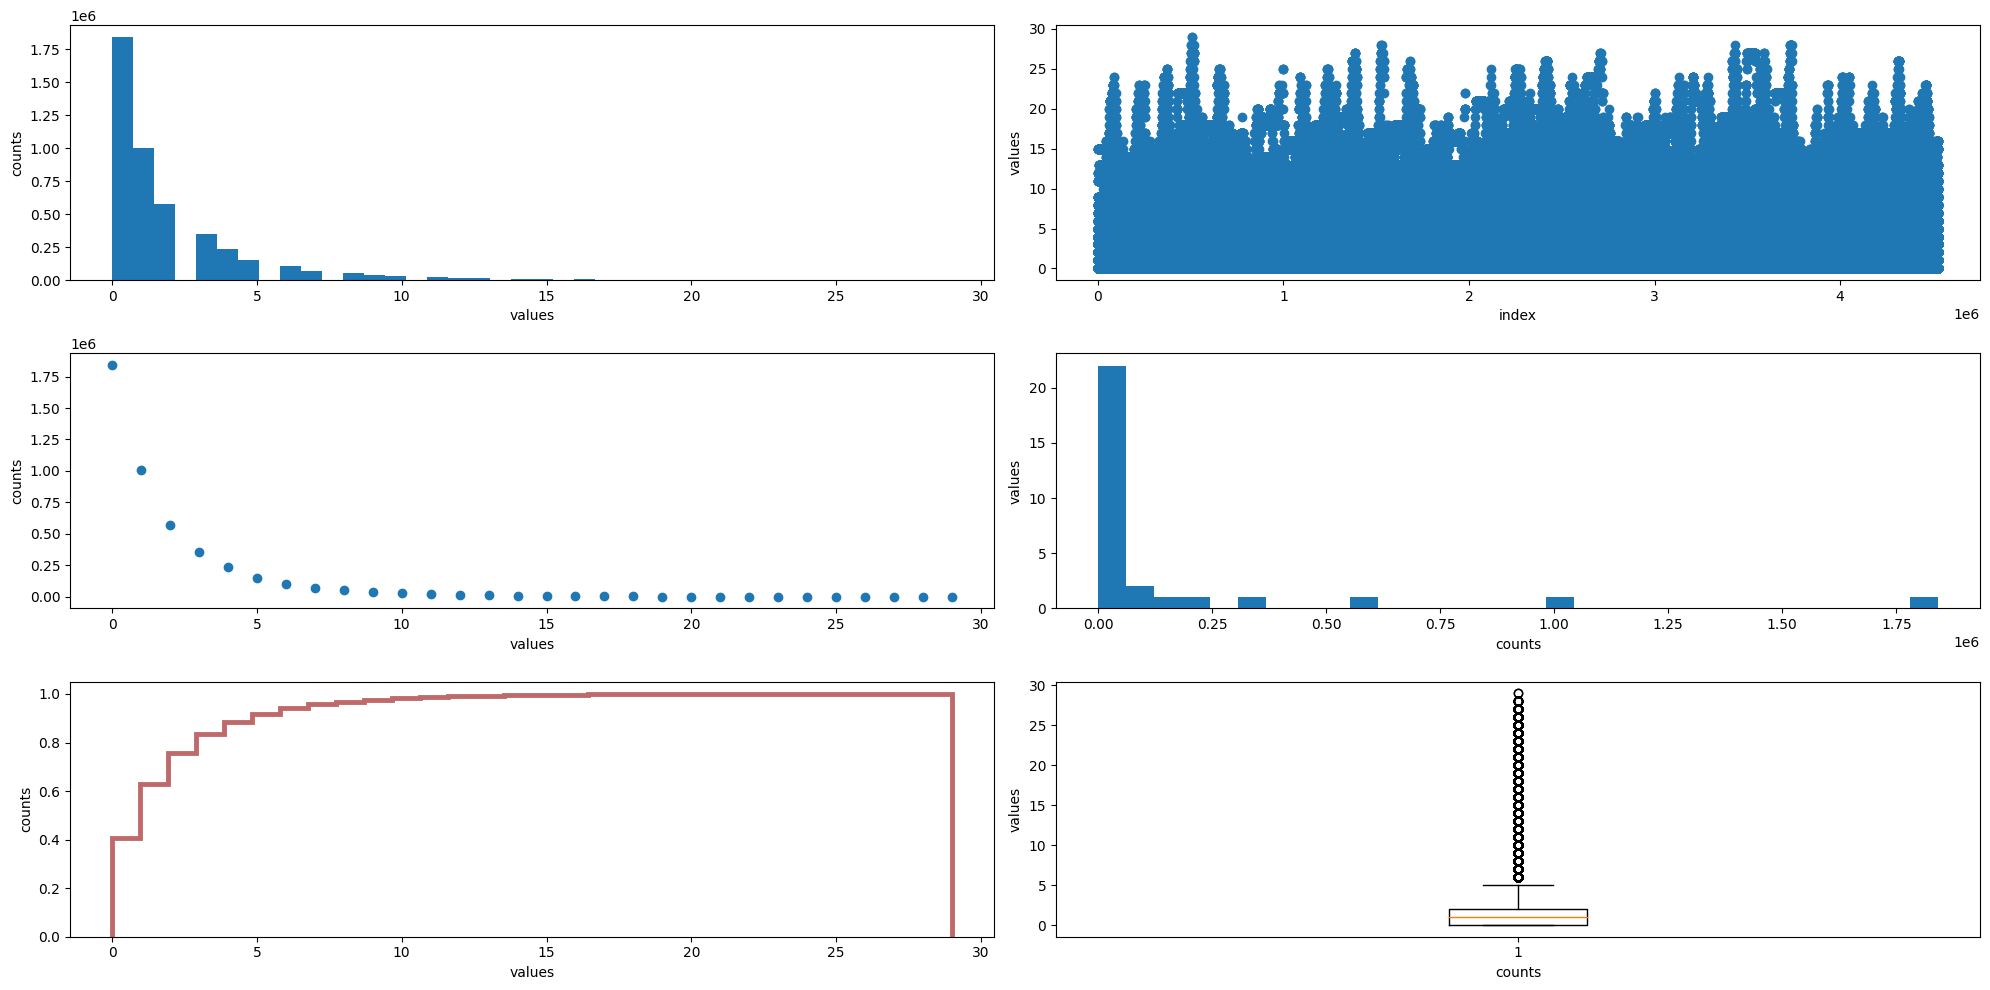

In [36]:
show_column_counts(dades_2021_Marc_info, 'num_bikes_available_types.ebike')

# Num docks available

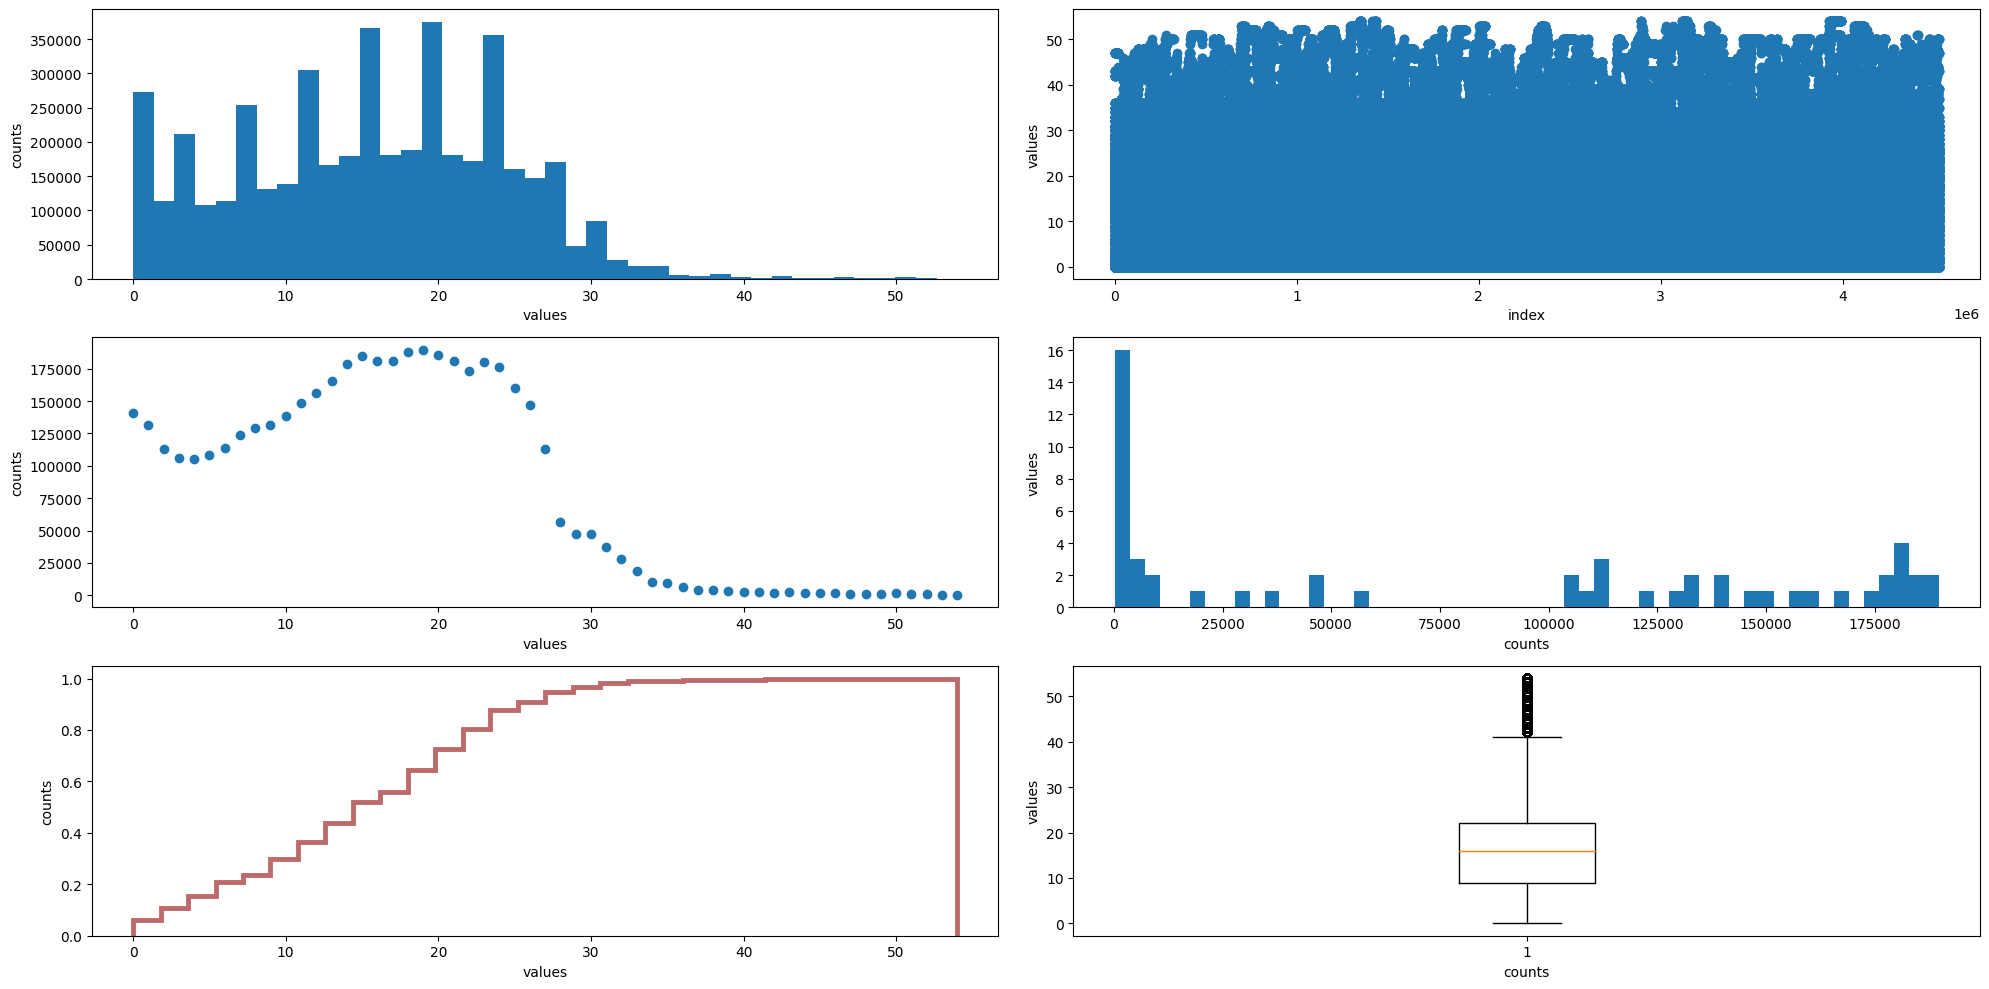

In [37]:
show_column_counts(dades_2021_Marc_info, 'num_docks_available')